**Aluno:** Douglas Leite Leal Moura

**Matrícula:** 2020715184

**Trabalho Prático I - Machine Learning**

_Classificação de Exoplanetas_

## 1. Introdução

### 1.1 Objetivo

O objetivo deste trabalho prático é de praticar os conceitos aprendidos na disciplina e de adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na interpretação e apresentação de resultados de experimentos. Para isso você irá utilizar e comparar métodos de classificação baseados em princı́pios diferentes em um problema de classificação binária de candidatos a exoplanetas.

* **Naive Bayes:** Apenas um experimento para servir de baseline
* **Decision Tree:** Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e
mostrar os resultados graficamente
* **SVM:** Avaliar os kernels linear, sigmoid, polinomial e RBF
* **k-NN:** Variar o número k de vizinhos e mostrar os resultados graficamente
* **Random Forest:** Variar o número de árvores e mostrar os resultados graficamente.
* **Gradient Tree Boosting:** Variar o número de iterações e mostrar os resultados graficamente

### 1.2 Instruções

Este trabalho utiliza a bibliteca _scikit-learn_ da linguagem Python (versão 3.6).

O ambiente virtual pode ser configurado mediante a execução dos seguintes comandos no terminal:

A sequência de comandos abaixo faz os imports necessários para a execução dos experimentos:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from tabulate import tabulate
# classificadores
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## 2. Conjunto de dados

O conjunto de dados foi importado utilizando _Pandas_, uma poderosa biblioteca Python criada para a manipulação e análise de dados.

O arquivo `koi_data.csv` trata-se do conjunto de dados utilizado neste problema de classificação binária de candidatos a exoplanetas. Um exoplaneta é um planeta fora do sistema solar (i.e. que não orbita o sol). A sonda primeiro identifica sinais de possı́veis exoplanetas, chamados de Kepler Object of Interest (KOI). Porém, nem todos os KOIs são de fato exoplanetas, alguns se tratam de falsos positivos de origens diversas. A tarefa é então classificar os KOIs entre exoplanetas confirmados e falsos positivos.

In [2]:
# caminho do arquivo
KOI_PATH = os.path.join("datasets", "TP1", "")

# funcao para importar o csv utilizando a lib pandas
def load_koi_data(koi_path=KOI_PATH):
    csv_path = os.path.join(koi_path, "koi_data.csv")
    return pd.read_csv(csv_path)

# importando dados
koi = load_koi_data()

A base de dados contém 5202 linhas e 43 colunas.

A primeira coluna identifica o KOI, a segunda traz a sua classificação correta (FALSE POSITIVE ou CONFIRMED) e as demais colunas são features sobre o KOI extraı́das de diversas formas.

In [3]:
koi.head() # Exibe as 5 primeiras linhas do dataset.

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Cada observação corresponde a um KOI e as features são caracterı́sticas estimadas de cada (possı́vel) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

### 2.1 Tratamento dos dados

A função `koi.info()` revelou que não havia dandos ausentes no conjunto de dados.

Sendo assim, não houve necessidade de adotar procedimentos para preencher os dados ausentes.

A partir de uma inspeção no conjunto de dados foi possível obter alguns _insights_. Por exemplo, a feature `kepoi_name` é um atributo categórico que descreve o nome do planeta, ela possui pouco potencial preditivo. Por isso, é interessante removê-la do conjunto de dados.

Em seguida, o atributo `koi_disposition` foi atribuído à variável `y_train` para ser utilizado como rótulo.

In [4]:
# verifica o tipo dos atributos e se existem dados faltantes.
koi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        5202 non-null   object 
 1   koi_disposition   5202 non-null   object 
 2   koi_period        5202 non-null   float64
 3   koi_impact        5202 non-null   float64
 4   koi_duration      5202 non-null   float64
 5   koi_depth         5202 non-null   float64
 6   koi_ror           5202 non-null   float64
 7   koi_srho          5202 non-null   float64
 8   koi_prad          5202 non-null   float64
 9   koi_sma           5202 non-null   float64
 10  koi_incl          5202 non-null   float64
 11  koi_teq           5202 non-null   float64
 12  koi_insol         5202 non-null   float64
 13  koi_dor           5202 non-null   float64
 14  koi_max_sngle_ev  5202 non-null   float64
 15  koi_max_mult_ev   5202 non-null   float64
 16  koi_model_snr     5202 non-null   float64


### 2.2 Distribuição dos dados

Após o tratamento inicial dos dados, observou-se a distribuição dos dados.

A função `X.describe()` sumariza algumas informações extraídas de cada feature, como a média, desvio padrão e os quartis.

No geral, foi possível perceber diferenças nas escalas dos atributos. Sendo necessário normalizar os dados. A fim de evitar vazamento de dados, a normalização foi realizada posteriormente, após o particionamento dos dados.

In [5]:
# remove a feature 'kepoi_name'.
columns = ['kepoi_name']
koi = koi.drop(columns=columns)

# remove a feature 'koi_position', pois ele e a classe que queremos predizer.
X = koi.drop("koi_disposition", axis=1)
y = koi["koi_disposition"].copy()

# fornece uma visao geral da distribuicao dos dados
X.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,37.032237,0.717106,5.607025,21340.318993,0.235205,3.415370,112.230798,0.158146,81.181413,1143.721069,...,-0.355681,-0.805629,-0.000263,0.000439,-0.049743,-0.087413,1.930251,-0.038402,-0.098738,1.920226
std,88.417985,2.628207,6.962634,66989.808550,2.586213,25.131368,3699.799318,0.241792,16.308839,775.788868,...,10.978677,14.741473,0.065707,0.077519,2.465670,2.746534,3.147553,2.465094,2.734732,3.142764
min,0.306940,0.000000,0.104600,0.800000,0.001290,0.000040,0.080000,0.007200,2.290000,92.000000,...,-275.600000,-397.620000,-4.000000,-0.800000,-21.500000,-75.900000,0.000000,-23.600000,-76.600000,0.000000
25%,2.213962,0.226000,2.500250,176.800000,0.013058,0.176092,1.460000,0.033000,81.930000,615.250000,...,-0.500000,-0.570000,-0.000240,-0.000240,-0.270000,-0.291500,0.128250,-0.265250,-0.320000,0.180000
50%,7.386755,0.610000,3.805500,495.950000,0.024185,0.748045,2.600000,0.073650,87.890000,948.000000,...,0.000000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.460000,-0.007000,-0.018000,0.453000
75%,23.448117,0.923750,6.000750,2120.525000,0.171260,2.267063,21.645000,0.158200,89.520000,1482.000000,...,0.500000,0.450000,0.000260,0.000280,0.230000,0.230000,2.570000,0.226250,0.250000,2.420000
max,1071.232620,100.806000,138.540000,864260.000000,99.870650,918.752390,200346.000000,2.034500,90.000000,9791.000000,...,97.780000,98.780000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,31.200000,89.600000


Por fim, foi analisado a distribuição dos exemplos entre as classes. O histograma revelou um certo desbalanceamento na distribução, onde cerca de 40.45% dos exemplos pertence a classe `CONFIRMED` e 59.55% pertence a classe `FALSE POSITIVE`, uma diferença de aproximadamente 19.10%.

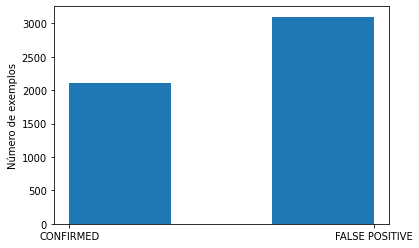

In [6]:
# plota um histograma da distribuição de y.
plt.hist(y, bins=3)
plt.ylabel('Número de exemplos')
plt.show()

## 3. Implementação


### 3.1 Funções Auxiliares

Algumas funções e classes foram implementadas para auxiliar os experimentos de treinamento e visualização dos resultados.

A classe `Scores` foi criada para facilitar o cálculo e visualização das métricas de desempenho.

O classificador irá treinar o modelo e registrar as métricas na classe `Scores` por meio do método `adicionar`. Esta classe também fornece a média e o desvio padrão da acurácia.

In [7]:
class Scores(object):
    """Registra as métricas de desempenho."""
    def __init__(self):
        self.accuracy = []
        self.fpr = []
        self.tpr = []
        self.precision = []
        self.recall = []
        self.f1 = []
        self.folds = 0
        
    def mean(self):
        """Retorna a media da acuracia."""
        return np.mean(self.accuracy)
    
    def std(self):
        """Calcula o desvio padrao da acuracia."""
        return np.std(self.accuracy)        
    
    def adicionar(self, accuracy, fpr, tpr, precision, recall, f1):
        """Adiciona as métricas de cada fold."""
        self.accuracy.append(accuracy)
        self.fpr.append(fpr)
        self.tpr.append(tpr)
        self.precision.append(precision)
        self.recall.append(recall)
        self.f1.append(f1)
        self.folds += 1 # incrementa o numero de folds

A função `show_scores` utiliza a biblioteca `tabulate` para produzir um relatório contendo as métricas de precision, recall, F1-score de cada fold, além de uma média. 

In [8]:
def show_scores(precision, recall, f1, folds):
        """Mostra uma tabela com as métricas de desempenho."""
        table = []
        matrix = np.zeros((folds, 4))
        
        # metrica para cada fold.
        for i in range(folds):
            row = []
            matrix[i,:] = [int(i), np.mean(precision[i]), np.mean(recall[i]), np.mean(f1[i])]
            row.append(i) # numero de folds
            row.append(format(matrix[i,1], '.3f')) # media do precision
            row.append(format(matrix[i,2], '.3f')) # media do recall
            row.append(format(matrix[i,3], '.3f')) # media do f1
            table.append(row)
        
        # media
        row = []
        media = list(matrix[:,1:].mean(0))
        row.append("Média")
        row.append(format(media[0], '.3f'))
        row.append(format(media[1], '.3f'))
        row.append(format(media[2], '.3f'))
        
        table.append(row)

        names = ["# fold", "Precision", "Recall", "F1-score"]
        table = tabulate(table, headers=names, tablefmt="pretty")
    
        return table

A função `plt_parametro` foi criada para facilitar a geração dos gráficos durante a variação dos parâmetros.

A função recebe o modelo e os valores que serão avaliados. Ao final, um gráfico é gerado com a curva da acurácia.

In [9]:
def plt_parametro(X, y, model, params, lim=None):
    """Função para gerar o gráfico da acurácia."""
    param_grid = ParameterGrid(params)
    
    mean = []
    std = []
    x = []
    xlab = list(params)[0]
    
    # treina cada modelo e salva as estatísticas
    for params in param_grid:
        x += (params.values())
        model.set_params(**params)
        clf = Classificador(X, y, model)
        clf.treinar()
        mean.append(clf.scores.mean())
        std.append(clf.scores.std())

    # Plota a média e o desvio padrão do cross-validation.
    plt.figure()
    mean = np.array(mean)
    std = np.array(std)
    plt.plot(x, mean)
    plt.fill_between(x,mean-std,mean+std,alpha=.1)
    plt.title("Acurácia do cross-validation")
    plt.xlabel(xlab)
    plt.ylabel("Acurácia")
    if lim == None:
        plt.ylim(0.8, 1)
    else:
        plt.ylim(lim, 1)
    plt.show()

A função `plt_roc` foi implementada para calcular e gerar o gráfico da curva ROC.

A função produz a curva de cada fold e, ao final, exige uma média. Para cada curva também foi calculado a área sub a curva (AUC).

In [10]:
def plt_roc(fpr, tpr, folds):
    """Função para gerar o gráfico da curva ROC."""
    
    plt.figure()
    mean_fpr = np.linspace(0,1,100)
    mean_auc = []
    tprs = []
    
    # Irá gerar uma curva para cada fold.
    for i in range(folds):
        roc_auc = auc(fpr[i], tpr[i]) # calcula area sob a curva (AUC)
        mean_auc.append(roc_auc)
        lbl = "Fold {} (AUC = {:.2f})".format(i, roc_auc)
        plt.plot(fpr[i], tpr[i], alpha=0.3, linewidth=2, label=lbl)
        tprs.append(np.interp(mean_fpr, fpr[i], tpr[i]))
    
    # Irá plotar a média dos folds
    mean_tpr = np.mean(tprs, axis=0)
    lbl = "Média (AUC = {:.2f})".format(np.mean(mean_auc))
    plt.plot(mean_fpr, mean_tpr, "b", linewidth=2, label=lbl)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("Curva ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

### 3.2 Método de Validação Cruzada

Como forma de melhor avaliar a capacidade de generalização dos modelos analisados, adotou-se o método de valizadação cruzada por meio do k-fold.

O conjunto de dados foi particionado em 5 folds. Desta forma, cada partição será utilizada para treino e teste.

Como forma de evitar vazamento de dados, o processo de normalização dos dados foi executado em cada fold seguindo a seguinte função:

`z = (x - u) / s`

Onde `u` é a média dos exemplos de treinamento `x` e `s` é o desvio padrão.

In [11]:
class Classificador(object):
    '''Classe responsável por treinar o modelo.'''
    
    def __init__(self, X, y, model, folds=5):
        
        self.X = X # Conjunto de dados
        self.y = y # Classe dos dados
        self.model = model # Modelo usado para treinar
        self.folds = folds # Numero de k-folds (default 5).
        self.scores = Scores() # Metricas do classificador
    
    def treinar(self):
        """Treina o classificador usando o k-fold."""

        skf = StratifiedKFold(n_splits=self.folds, shuffle=False)

        for train_index, test_index in skf.split(self.X, self.y):
            X_train,X_test = X.iloc[train_index],X.iloc[test_index]
            y_train,y_test = y.iloc[train_index],y.iloc[test_index]

            # normalização
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # treinamento
            self.model.fit(X_train,y_train)
            y_pred = self.model.predict(X_test).reshape(-1,)
            
            # calcula todos os scores
            accuracy = accuracy_score(y_test, y_pred) # acurácia
            y_pred_proba = self.model.predict_proba(X_test)[::,0]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label="CONFIRMED") # curva roc
            precision = precision_score(y_test, y_pred, pos_label='CONFIRMED', zero_division=0) # precision
            recall = recall_score(y_test, y_pred, pos_label='CONFIRMED', zero_division=0) # recall
            f1 = f1_score(y_test, y_pred, pos_label='CONFIRMED', zero_division=0) # f1-score
            
            # salva os scores
            self.scores.adicionar(accuracy, fpr, tpr, precision, recall, f1)

        return self.model

Para facilitar o processo de descoberta do melhor conjunto de hiper-parâmetros, foi proposta uma função `find_parameters`, que recebe como entrada o conjunto de dados, a classe, o modelo e um dicionário de hiper-parâmetros.

A função irá realizar todas as combinações, treinar o algoritmo e, ao final, informar qual configuração obteve a melhor acurácia.

In [12]:
def find_parameters(X, y, model, params, imprimir=True):
    """Função responsável por analisar os parâmetros do modelo."""
    
    param_grid = ParameterGrid(params)
    best_score = 0
    best_params = None
    best_clf = None
    
    print("Analisando ({}) combinações de parâmetros:".format(len(param_grid)))
    print("+----------------------------------------+")
    for params in param_grid:
        model.set_params(**params)
        clf = Classificador(X, y, model)
        clf.treinar()
        
        # verifica se a acuracia é melhor que a atual.
        if clf.scores.mean() > best_score:
            best_score = clf.scores.mean()
            best_params = params
            best_clf = clf
        
        if imprimir:
            print("Acurácia: {:.3f} (+/- {:.3f}) for {} ".format(clf.scores.mean(), clf.scores.std(), params))
    
    print("+----------------------------------------+")
    print("Melhor combinação: {}".format(best_params))
    return best_clf

## 4. Experimentos

Esta parte do documento relata os resultados para cada algoritmo, em que diferentes combinações de hiper-parâmetros foram testadas.

### 4.1. Naive Bayes

**Tarefa:** Apenas um experimento para servir de baseline.

Para esta tarefa foi utilizado o classificador `GaussianNB`. Não foi solicitado nenhuma análise de parâmetro.

Analisando (1) combinações de parâmetros:
+----------------------------------------+
Acurácia: 0.919 (+/- 0.017) for {} 
+----------------------------------------+
Melhor combinação: {}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.826   | 0.950  |  0.884   |
|   1    |   0.831   | 0.971  |  0.896   |
|   2    |   0.865   | 0.976  |  0.917   |
|   3    |   0.888   | 0.995  |  0.938   |
|   4    |   0.849   | 0.948  |  0.895   |
| Média  |   0.852   | 0.968  |  0.906   |
+--------+-----------+--------+----------+


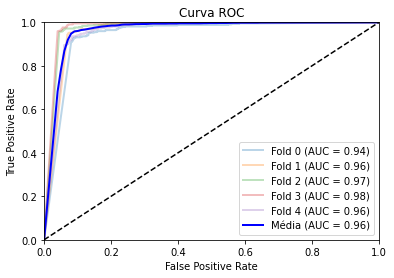

In [13]:
gnb = GaussianNB() # Classificador

params = {} # Hiper-parametros

gnb = find_parameters(X, y, gnb, params) # Melhor classificador

s = gnb.scores # Estatisticas do melhor
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

O Naive Bayes obteve uma acurácia de aproximadamente 92%. Em termos gerais, o classificador mostrou uma boa performance para o problema em questão, sendo capaz de classificar corretamente quase todas as instâncias de teste.

As medidas de precisão e revocação fornecem uma análise mais detalhada da performance do classificador.

A precisão foi por volta de 85%, cerca de 15% dos planetas foram classificados como `CONFIRMED` quando na verdade eram `FALSE POSITIVE`.

Por outro lado, a revocação de quase 97% sugere que o Naive Bayes conseguiu classificar bem casos onde o planeta era de fato `CONFIRMED`, estes resultados sugerem que o classificador possui uma alta sensibilidade aos casos positivos.

Por fim, o F1-Score também foi calculado. Para este caso, devido a precisão de 85%, o F1-Score foi de 90%.

Conforme será visto nos resultados abaixo, outros classificadores obtiveram uma precisão acima de 90%.

### 4.2. Decision Tree

**Tarefa:** Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e
mostrar os resultados graficamente.

Para esta tarefa foi utilizado o classificador `DecisionTreeClassifier`.

Além da altura máxima da árvore (objetivo da tarefa), os seguintes parâmetros também foram avaliados:

* **max_depth** = {2, 4, 8, 16, 32, 64, **None**} - altura máxima da árvore. Em None, a árvore irá crescer de forma ilimitada.
* **criterion** = {entropy, **gini**} - medida de impureza
* **min_samples_split** = {**2**, 4, 8, 16, 32} - número mínimo de exemplos para ramificar um nó.
* **min_samples_leaf** = {**1**, 2, 3, 4} - número mínimo de exemplos para um nó ser uma folha.

Os valores em **negrito** destacam valores default de cada hiperparâmetro do classificador.

O objetivo deste experimento foi analisadar como diferentes combinações de hiperparâmetros produzem árvores distintas. 


Analisando (200) combinações de parâmetros:
+----------------------------------------+
+----------------------------------------+
Melhor combinação: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 32}
Acurácia Média: 0.955
Desvio Padrão: 0.012
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.890   | 0.964  |  0.926   |
|   1    |   0.943   | 0.945  |  0.944   |
|   2    |   0.951   | 0.964  |  0.958   |
|   3    |   0.947   | 0.981  |  0.964   |
|   4    |   0.953   | 0.914  |  0.933   |
| Média  |   0.937   | 0.954  |  0.945   |
+--------+-----------+--------+----------+


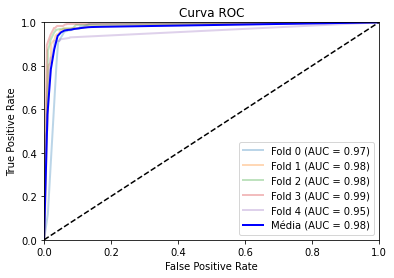

In [14]:
# Parametros avaliados
params = {"max_depth":[2, 4, 8, 16, None],
          "criterion":["entropy", "gini"],
          "min_samples_split":[2, 4, 8, 16, 32],
          "min_samples_leaf":[1, 2, 3, 4]}

tree = DecisionTreeClassifier() # Classificador

tree = find_parameters(X, y, tree, params, False) # Busca pelo melhor classificador

s = tree.scores # Estatisticas do melhor
print("Acurácia Média: {:.3f}".format(np.mean(s.accuracy)))
print("Desvio Padrão: {:.3f}".format(np.std(s.accuracy)))
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

A árvore de decisão resultante pode ser visualizada abaixo com o auxílio da função **plot_tree**:

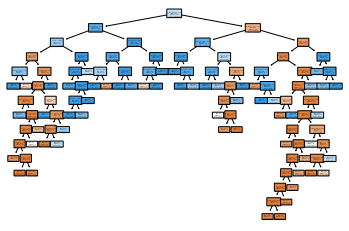

In [15]:
feature_names = list(X.columns.values)
class_names = tree.model.classes_

# plota a melhor árvore encontrada
plt.figure()
plot_tree(tree.model,
               feature_names=feature_names,
               class_names=class_names,
               filled=True, rounded=True) 
plt.show()

Os resultados reportados apontam que a **melhor altura foi 8** (para os hiperparâmetros avaliados).

A melhor árvore de decisão obteve uma **acurácia média de 95.50%** com um desvio padrão de 1.2%.

Em relação ao Naive Bayes, é importante destacar o aprimoramento da precisão. Desta vez, o classificador obteve uma precisão de cerca de 93.70%. Houve uma melhora de quase 4% no F1-score.

A altura máxima da árvore teve a maior influência no desempenho do classificador, porém o ajuste apropriado das políticas de ramificação da árvore e criação do nó folha trouxeram um certo aprimoramento. Com os valores default, a precisão diminiu em quase 1.2%.

In [16]:
params = {"max_depth":[8],
          "criterion":["entropy"]}

default = DecisionTreeClassifier()

# classificador com alguns parâmetros default.
default = find_parameters(X, y, default, params)
s = default.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

Analisando (1) combinações de parâmetros:
+----------------------------------------+
Acurácia: 0.952 (+/- 0.009) for {'criterion': 'entropy', 'max_depth': 8} 
+----------------------------------------+
Melhor combinação: {'criterion': 'entropy', 'max_depth': 8}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.888   | 0.979  |  0.931   |
|   1    |   0.925   | 0.943  |  0.934   |
|   2    |   0.925   | 0.971  |  0.948   |
|   3    |   0.943   | 0.976  |  0.959   |
|   4    |   0.955   | 0.914  |  0.934   |
| Média  |   0.927   | 0.957  |  0.941   |
+--------+-----------+--------+----------+


O próximo experimento analisou apenas a altura máxima da árvore.

O valor da altura máxima foi variado de 2 à 20 (a altura máxima que a árvore atingiu quando **None**).

Conforme os resultados relatados anteriormente, crescer a árvore indiscriminadamente não melhora a acurácia.

A curva da acurácia cresce entre 2 e 6. Em seguida, a função estabiliza-se próximo a 95%.

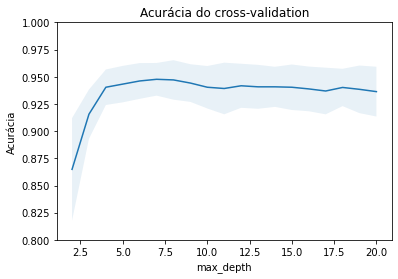

In [17]:
params = {"max_depth":range(2, 21)} # Variando apenas a altura da árvore

tree_2 = DecisionTreeClassifier()
plt_parametro(X, y, tree_2, params)

Altura máxima igual a 2:

In [18]:
tree2 = DecisionTreeClassifier(max_depth=2)
tree2 = Classificador(X, y, tree2)
tree2.treinar()

s = tree2.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.806   | 0.720  |  0.760   |
|   1    |   0.796   | 0.760  |  0.778   |
|   2    |   0.876   | 0.969  |  0.920   |
|   3    |   0.887   | 0.893  |  0.890   |
|   4    |   0.902   | 0.681  |  0.776   |
| Média  |   0.853   | 0.805  |  0.825   |
+--------+-----------+--------+----------+


Altura máxima igual a 5:

In [19]:
tree5 = DecisionTreeClassifier(max_depth=5)
tree5 = Classificador(X, y, tree5)
tree5.treinar()

s = tree5.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.866   | 0.964  |  0.912   |
|   1    |   0.918   | 0.957  |  0.937   |
|   2    |   0.921   | 0.971  |  0.946   |
|   3    |   0.938   | 0.971  |  0.954   |
|   4    |   0.910   | 0.895  |  0.903   |
| Média  |   0.911   | 0.952  |  0.930   |
+--------+-----------+--------+----------+


Altura máxima igual a 8:

In [20]:
tree8 = DecisionTreeClassifier(max_depth=8)
tree8 = Classificador(X, y, tree8)
tree8.treinar()

s = tree8.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.865   | 0.962  |  0.911   |
|   1    |   0.930   | 0.952  |  0.941   |
|   2    |   0.934   | 0.974  |  0.953   |
|   3    |   0.951   | 0.971  |  0.961   |
|   4    |   0.900   | 0.879  |  0.889   |
| Média  |   0.916   | 0.948  |  0.931   |
+--------+-----------+--------+----------+


Altura máxima permitida:

In [21]:
tree_max = DecisionTreeClassifier(max_depth=None)
tree_max = Classificador(X, y, tree_max)
tree_max.treinar()

s = tree_max.scores
print(show_scores(s.precision, s.recall, s.f1, s.folds))

+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.880   | 0.938  |  0.908   |
|   1    |   0.928   | 0.948  |  0.938   |
|   2    |   0.947   | 0.941  |  0.944   |
|   3    |   0.955   | 0.952  |  0.954   |
|   4    |   0.911   | 0.850  |  0.879   |
| Média  |   0.924   | 0.926  |  0.925   |
+--------+-----------+--------+----------+


### 4.3. SVM

**Tarefa:** Avaliar os kernels linear, sigmoid, polinomial e RBF.

Foi utilizado o classificador `SVC`, que implementa todos as funções kernels solicitados neste trabalho.

Para esta tarefa, cada kernel foi devidamente avaliado com diferentes combinações de parâmetros.

Em todos os experimentos: 

* **probability** foi fixado em True. Este procedimento foi necessário para calcular a curva ROC.
* **C** = {0.001, 0.01, 0.1, 1, 10, 100}.

C é um parâmetro de regularização, responsável por aplicar penalidades aos exemplos que ultrapassam a margem do SVM.

O SVM é um classificador que trabalha com o conceito de margem máxima. Ele irá ajustar um limite de decisão que permita minimizar o erro de classificação ao passo que busca maximizar a margem que separa os exemplos das duas classes.

Quando C é suficientemente grande (tendendo ao infinito), o SVM não irá permitir violações de margem.
Este hiper-parâmetro possui um alto impacto na performance do algoritmo (acurácia e custo computacional). Por isso ele foi avaliado em todos os cenários.

Além disso, cada função kernel possui hiper-parâmetros específicos que foram analisados.
Os resultados serão relatados a seguir.

#### 4.3.1 Kernel Linear

A primeira função kernel avaliada foi o kernel linear.

Embora produza hipóteses mais simples, o kernel linear obteve resultados interessantes.

Com o parâmetro C = 10, foi possível obter uma acurácia de 95.3%.

Note que a precision e o recall também foram superiores a 90%.

Analisando (6) combinações de parâmetros:
+----------------------------------------+
+----------------------------------------+
Melhor combinação: {'C': 10, 'kernel': 'linear', 'probability': True}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.882   | 0.974  |  0.926   |
|   1    |   0.936   | 0.974  |  0.955   |
|   2    |   0.966   | 0.957  |  0.962   |
|   3    |   0.948   | 0.962  |  0.955   |
|   4    |   0.911   | 0.926  |  0.919   |
| Média  |   0.929   | 0.959  |  0.943   |
+--------+-----------+--------+----------+
Acurácia Média: 0.953
Desvio Padrão: 0.015


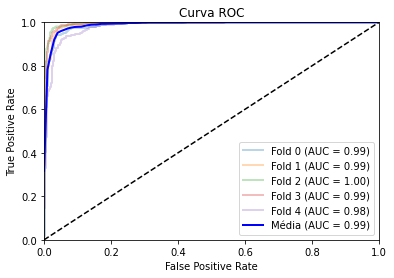

In [22]:
params = {"C":[0.001, 0.01, 0.1, 1, 10, 100],
          "kernel":["linear"],
          "probability":[True]}

k_linear = SVC() # classificador

k_linear = find_parameters(X, y, k_linear, params, False) # Melhor classificador

s = k_linear.scores # Estatisticas do melhor
print(show_scores(s.precision, s.recall, s.f1, s.folds))
print("Acurácia Média: {:.3f}".format(np.mean(s.accuracy)))
print("Desvio Padrão: {:.3f}".format(np.std(s.accuracy)))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

O gráfico a seguir mostra a acurácia média do cross-validation para diferentes valores de C.

Aqui, foi incluído o C = 0.001.

O parâmetro de regularização é um mecanismo importante para evitar que o modelo se ajuste excessivamente aos dados. Porém, o excesso de regularização pode produzir modelos extretamente simples, a ponto da hipótese se distanciar da função alvo.

Esse problema será mais evidente no caso do kernel sigmoide.

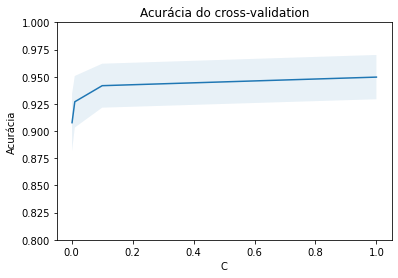

In [23]:
# Variando apenas C.
params = {"C":[0.001, 0.01, 0.1, 1]}

svm = SVC(kernel="linear", probability = True)
plt_parametro(X, y, svm, params)

#### 4.3.2 Kernel Sigmoid

Dentre as funcões avaliadas, o kernel sigmoide obteve os piores resultados.

A melhor configuração obteve 87.2% de acurácia usando C = 0.1.

A precisão do modelo também não foi tão, beirando aos 80%.

Analisando (10) combinações de parâmetros:
+----------------------------------------+
+----------------------------------------+
Melhor combinação: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': True}
Acurácia Média: 0.872
Desvio Padrão: 0.036
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.750   | 0.957  |  0.841   |
|   1    |   0.836   | 0.919  |  0.876   |
|   2    |   0.846   | 0.929  |  0.886   |
|   3    |   0.837   | 0.936  |  0.883   |
|   4    |   0.732   | 0.831  |  0.778   |
| Média  |   0.800   | 0.914  |  0.853   |
+--------+-----------+--------+----------+


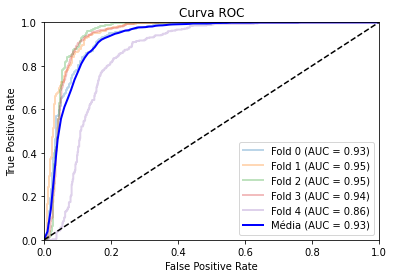

In [24]:
params = {"C":[0.001, 0.1, 1, 10, 100],
          "kernel":["sigmoid"],
          "gamma":["scale", "auto"],
          "probability":[True]}

k_sigmoid = SVC() # Classificador

k_sigmoid = find_parameters(X, y, k_sigmoid, params, False) # Melhor classificador

s = k_sigmoid.scores # Estatisticas do melhor
print("Acurácia Média: {:.3f}".format(np.mean(s.accuracy)))
print("Desvio Padrão: {:.3f}".format(np.std(s.accuracy)))
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

Quando C é muito pequeno, o classificador tende a cometer muitos erros de classificação. Isso acontece porque o classificador irá tolerar um grande número de violações de margem, levando a um ajuste inapropriado do limite de decisão.

Os resultados obtidos para C = 0.001 sugerem que o classificador sofreu um **underfitting**, onde este está com uma acurácia um pouco maior que 50%.

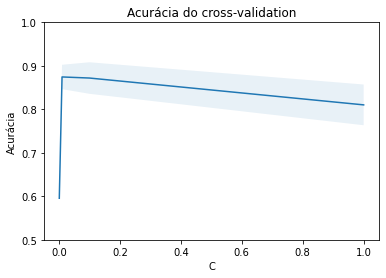

In [25]:
# Variando apenas C
params = {"C":[0.001, 0.01, 0.1, 1]}

svm = SVC(kernel="sigmoid", probability = True)
plt_parametro(X, y, svm, params, 0.5)

#### 4.3.3 Kernel Polinomial

Para o kernel polinomial, foi avaliado o `degree` igual a 2 e 3.

Destes, o grau 2 com C = 100 obteve o melhor resultado: quase 94% de acurácia.

Analisando (20) combinações de parâmetros:
+----------------------------------------+
+----------------------------------------+
Melhor combinação: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}
Acurácia Média: 0.939
Desvio Padrão: 0.017
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.851   | 0.960  |  0.902   |
|   1    |   0.924   | 0.950  |  0.937   |
|   2    |   0.907   | 0.952  |  0.929   |
|   3    |   0.941   | 0.976  |  0.958   |
|   4    |   0.891   | 0.933  |  0.912   |
| Média  |   0.903   | 0.954  |  0.928   |
+--------+-----------+--------+----------+


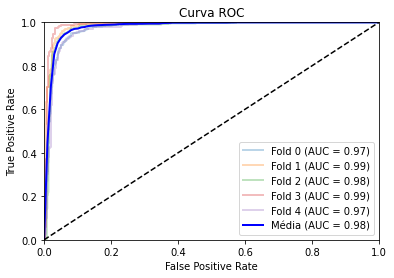

In [26]:
params = {"C":[0.01, 0.1, 1, 10, 100],
          "kernel":["poly"],
          "degree":[2, 3],
          "gamma":["scale", "auto"],
          "probability":[True]}

k_poly = SVC() # Classificador

k_poly = find_parameters(X, y, k_poly, params, False) # Melhor classificador

s = k_poly.scores # Estatisticas do melhor
print("Acurácia Média: {:.3f}".format(np.mean(s.accuracy)))
print("Desvio Padrão: {:.3f}".format(np.std(s.accuracy)))
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

Assim como no kernel sigmoid, o C = 0.001 trouxe o pior desempenho de classificação. Cerca de 60% de acurácia.

Em contrapartida, o aumento do hiper-parâmetro C trouxe uma melhora considerável. Embora o sigmoide tenha ficado abaixo de 90%, o kernel polinomial teve uma acurácia quase 94% quando C = 100.

Além disso, a precisão melhorou em 10%.

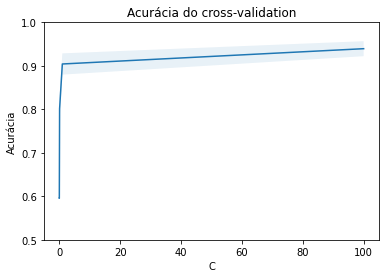

In [27]:
# Variando apenas C
params = {"C":[0.001, 0.01, 0.1, 1, 100]}

svm = SVC(kernel="poly", degree=2, probability = True)
plt_parametro(X, y, svm, params, 0.5)

#### 4.3.4 Kernel RBF

Por fim, o kernel RBF também foi analisado.

Seus resultados seguiram a tendência do kernel linear e do polinomial, ficando em torno de 94%.

Assim como no polinomial, o melhor resultado foi com C = 100, enquanto que C = 0.001 teve o pior resultado.

Analisando (12) combinações de parâmetros:
+----------------------------------------+
+----------------------------------------+
Melhor combinação: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Acurácia Média: 0.947
Desvio Padrão: 0.015
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.870   | 0.955  |  0.911   |
|   1    |   0.929   | 0.962  |  0.945   |
|   2    |   0.951   | 0.960  |  0.955   |
|   3    |   0.957   | 0.943  |  0.950   |
|   4    |   0.931   | 0.902  |  0.917   |
| Média  |   0.927   | 0.944  |  0.935   |
+--------+-----------+--------+----------+


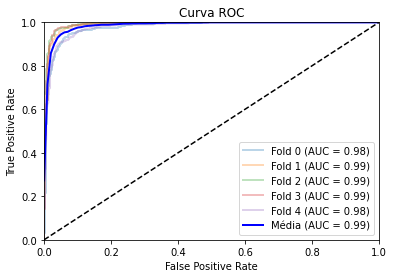

In [28]:
params = {"C":[0.001, 0.01, 0.1, 1, 10, 100],
          "kernel":["rbf"],
          "gamma":["scale", "auto"],
          "probability":[True]}

k_rbf = SVC() # Classificador

k_rbf = find_parameters(X, y, k_rbf, params, False) # Melhor classificador

s = k_rbf.scores # Estatisticas do melhor
print("Acurácia Média: {:.3f}".format(np.mean(s.accuracy)))
print("Desvio Padrão: {:.3f}".format(np.std(s.accuracy)))
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

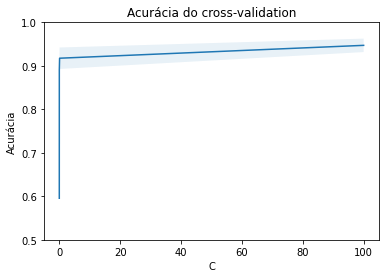

In [29]:
# Variando C.
params = {"C":[0.001, 0.01, 0.1, 100]}

svm = SVC(kernel="rbf", probability = True)
plt_parametro(X, y, svm, params, 0.5)

#### 4.3.5 Comparação

Esta seção sumariza os principais resultados alcançados pelo SVM.

O gráfico abaixo mostra a acurácia média obtida pela melhor combinação de parâmetros em cada função kernel.

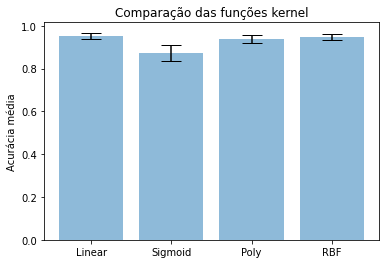

In [30]:
fig, ax = plt.subplots()

x = np.arange(4)

# média
results = []
results.append(np.mean(k_linear.scores.mean()))
results.append(np.mean(k_sigmoid.scores.mean()))
results.append(np.mean(k_poly.scores.mean()))
results.append(np.mean(k_rbf.scores.mean()))

# desvio padrão
error = []
error.append(np.mean(k_linear.scores.std()))
error.append(np.mean(k_sigmoid.scores.std()))
error.append(np.mean(k_poly.scores.std()))
error.append(np.mean(k_rbf.scores.std()))

plt.bar(x, results, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(x, ('Linear', 'Sigmoid', 'Poly', 'RBF'))
plt.ylabel('Acurácia média')
plt.title("Comparação das funções kernel")
plt.show()


Conforme relatado anteriormente:

* O Kernel Sigmoide teve o pior desempenho.
* Ao passo que o kernel linear teve o melhor (vencendo em todas as métricas avaliadas).
* O hyper-parâmetro C foi melhor com 10 e 100.

Este último resultado evidencia a importância de manter um bom balanço entre especificidade e generalização. Nos casos onde houve abuso da regularização, o classificador chegou próximo de errar métade dos exemplos.

Kernel  | Acurácia | Precisão | Revocação | F1-Score
---------  | ------ | ------ | ------ | ------
Linear  | **95.30** | **92.90** | **95.90** | **94.30**
Sigmoid | 87.20 | 80.00 | 91.40 | 85.30
Poly    | 93.90 | 90.30 | 95.40 | 92.80
RBF     | 94.70 | 92.70 | 94.40 | 93.50 

#### 4.4. k-NN

**Tarefa**: Variar o número k de vizinhos e mostrar os resultados graficamente.

O K-NN é um classificador que baseia-se no cálculo da distância para os k-vizinhos mais próximos. Onde uma nova instância será classificada de acordo com a classificação majoritária dos k-vizinhos mais próximos.

O objetivo deste experimento foi avaliar o desepenho do k-NN para diferentes valores de K:

* **n_neighbors** = {1, 2, ..., 80} Número K de vizinhos mais próximos.

A distância utilizada foi `minkowski` com p=2. Deste modo, a distância obtida foi equivalente à distância euclidiana, dada por:

`sqrt(sum((x - y)^2))`

Analisando (80) combinações de parâmetros:
+----------------------------------------+
+----------------------------------------+
Melhor combinação: {'n_neighbors': 3}
Acurácia Média: 0.888
Desvio Padrão: 0.027
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.732   | 0.943  |  0.825   |
|   1    |   0.812   | 0.964  |  0.882   |
|   2    |   0.837   | 0.941  |  0.886   |
|   3    |   0.847   | 0.971  |  0.905   |
|   4    |   0.824   | 0.924  |  0.871   |
| Média  |   0.810   | 0.949  |  0.874   |
+--------+-----------+--------+----------+


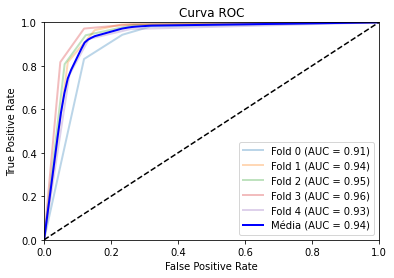

In [31]:
params = {"n_neighbors":range(1,81)} # hiper-parâmetros avaliados

knn = KNeighborsClassifier() # Classificador

knn = find_parameters(X, y, knn, params, False) # Melhor classificador

s = knn.scores # Estatisticas do melhor
print("Acurácia Média: {:.3f}".format(np.mean(s.accuracy)))
print("Desvio Padrão: {:.3f}".format(np.std(s.accuracy)))
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

No geral, para este problema, observou-se que o K-NN não melhora com o aumento de K.

O **melhor resultado foi k = 3**. Após isso, a acurácia passa a cair gradativamente conforme K cresce em tamanho. Este comportamento sugere que instância de classes diferentes estão bem próximas das outras, por isso, vizinhanças maiores podem levar a classificações incorretas.

Além disso, foi possível perceber uma queda sempre que K assumia valores pares.

Tipicamente, costuma-se adotar valores ímpares para K como forma de evitar impasses durante a classificação.
Por exemplo, uma instância onde os K vizinhos mais próximos estão perfeitamente distribuídos entre as duas classes: 50% classe A e 50% classe B. Um número ímpar resolve esta situação de impasse.



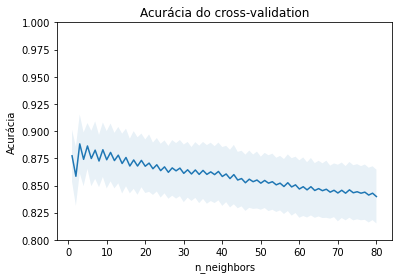

In [32]:
# Variando o número de k vizinhos
params = {"n_neighbors":range(1, 81)}

knn_2 = KNeighborsClassifier()
plt_parametro(X, y, knn_2, params)

#### 4.5. Random Forest

**Tarefa**: Variar o número de árvores e mostrar os resultados graficamente.


Uma Random Forest utiliza várias árvores de decisão em várias subamostras do conjunto de dados e usa a média para melhorar a precisão e o controle de overfitting.

O número de árvores é um hiper-parâmetro deste classificador. E, ele foi variado conforme mostrado a seguir:

* **n_estimators** = {1, 100, 200, 500, 1000}

O melhor resultado foi obtido utilizando no mínimo **100 árvores**. Com 1000 árvores foi possível obter o mesmo resultado, porém produzindo 10x mais árvores de decisão.

Além disso, o classificador obteve valores acima de 95% para todas as métricas avaliadas.

Analisando (5) combinações de parâmetros:
+----------------------------------------+
Acurácia: 0.931 (+/- 0.019) for {'n_estimators': 1} 
Acurácia: 0.967 (+/- 0.013) for {'n_estimators': 100} 
Acurácia: 0.965 (+/- 0.013) for {'n_estimators': 200} 
Acurácia: 0.968 (+/- 0.012) for {'n_estimators': 500} 
Acurácia: 0.967 (+/- 0.012) for {'n_estimators': 1000} 
+----------------------------------------+
Melhor combinação: {'n_estimators': 500}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.909   | 0.971  |  0.939   |
|   1    |   0.967   | 0.971  |  0.969   |
|   2    |   0.971   | 0.962  |  0.967   |
|   3    |   0.983   | 0.974  |  0.979   |
|   4    |   0.980   | 0.919  |  0.948   |
| Média  |   0.962   | 0.960  |  0.960   |
+--------+-----------+--------+----------+


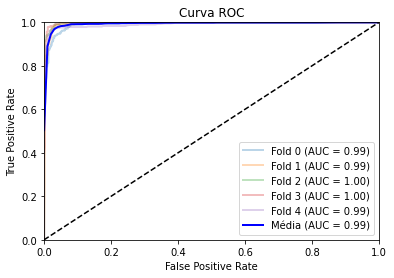

In [33]:
params = {"n_estimators":[1, 100, 200, 500, 1000]} # hiper-parametros

forest = RandomForestClassifier() # Classficador

forest = find_parameters(X, y, forest, params) # Melhor classificador

s = forest.scores # Estatisticas do melhor
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

Nota-se que após 100 árvores a acurácia parou de crescer.

Por isso, um experimento adicionou foi realizado para analisar pequenos valores entre 1 a 128.

Os resultados mostraram que com 20 árvores é possível ter uma acurácia próxima a 95%.

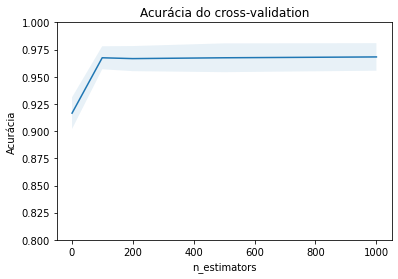

In [34]:
params = {"n_estimators":[1, 100, 200, 500, 1000]} # variando o numero de árvores

forest2 = RandomForestClassifier()
plt_parametro(X, y, forest2, params)

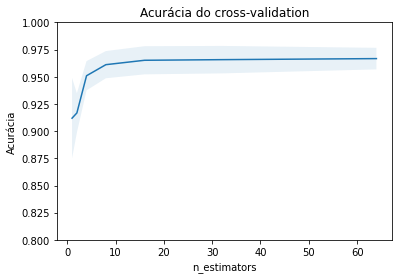

In [35]:
params = {"n_estimators":[1, 2, 4, 8, 16, 32, 64]} # variando o numero de árvores

forest2 = RandomForestClassifier()
plt_parametro(X, y, forest2, params)

#### 4.6. Gradient Tree Boosting

**Tarefa:** Variar o número de iterações e mostrar os resultados graficamente.

Por fim, o último classificador estudado foi o `Gradient Tree Boosting`. Este é outro classificador baseado em árvores de decisão.

O hiper-parâmetro foi variado da seguinte forma:

* **n_estimators** = {1, 100, 200, 500, 1000}

Assim como em outros classificadores baseados em árvores de decisão, foi possível classificar corretamente quase 100% dos exemplos.

O Gradient Tree Boosting obteve a melhor acurácia dentre todos os algoritmos avaliados, chegando a 97.1% de acurácia, 95.6% de precisão e uma revocação de 97.4%.

Estes resultados sugerem que o classificador é preciso na hora de classificar um KOI como um planeta e possui uma alta sensibilidade aos falsos positivos.

Analisando (5) combinações de parâmetros:
+----------------------------------------+
Acurácia: 0.596 (+/- 0.000) for {'n_estimators': 1} 
Acurácia: 0.965 (+/- 0.012) for {'n_estimators': 100} 
Acurácia: 0.968 (+/- 0.011) for {'n_estimators': 200} 
Acurácia: 0.969 (+/- 0.014) for {'n_estimators': 500} 
Acurácia: 0.970 (+/- 0.013) for {'n_estimators': 1000} 
+----------------------------------------+
Melhor combinação: {'n_estimators': 1000}
+--------+-----------+--------+----------+
| # fold | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|   0    |   0.894   | 0.986  |  0.938   |
|   1    |   0.956   | 0.974  |  0.965   |
|   2    |   0.965   | 0.986  |  0.975   |
|   3    |   0.976   | 0.986  |  0.981   |
|   4    |   0.980   | 0.938  |  0.959   |
| Média  |   0.954   | 0.974  |  0.964   |
+--------+-----------+--------+----------+


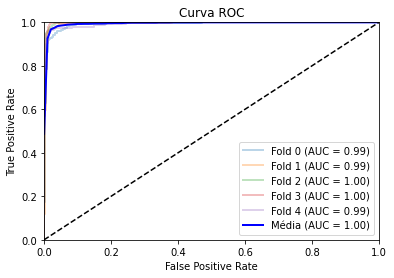

In [36]:
params = {"n_estimators":[1, 100, 200, 500, 1000]} # hiper-parametros

gtb = GradientBoostingClassifier() # classificador

gtb = find_parameters(X, y, gtb, params) # Melhor classificador

s = gtb.scores # Estatisticas do melhor
print(show_scores(s.precision, s.recall, s.f1, s.folds))

plt_roc(s.fpr, s.tpr, s.folds) # Curva ROC do melhor

Analogamente ao random forest, o hiper-parâmetro foi variado com dois conjuntos diferentes.

O primeiro mostrou que entre 100 e 1000 há pouca variação na acurácia.

O segundo mostrou um crescimento até 20, após isso a curva estabiliza-se.

Variando até 1000 é possível obter um ganho de menos de 1%, onde houve um desvio padrão de aproximadamente 1%. É necessário replicar o algoritmo mais vezes e verificar se há diferença estatística entre 20 e 1000.

Este passo é interesse pois pode reduzir o consumo de recursos computacionais.

In [ ]:
# Variando o numero de itaracoes
params = {"n_estimators":[1, 100, 200, 500, 1000]}

gtb_2 = GradientBoostingClassifier()
plt_parametro(X, y, gtb_2, params, 0.5)

In [ ]:
# Variando o numero de itaracoes
params = {"n_estimators":[1, 2, 4, 8, 16, 32, 64]}

gtb_2 = GradientBoostingClassifier()
plt_parametro(X, y, gtb_2, params, 0.5)

### 5. Resultados Finais

Por fim, esta seção sumariza os principais resultados obtidos após treinar e avaliar os hiper-parâmetros de cada classificador.

Com excessão do naive bayes e do K-NN (piores resultados), os classificadores tiveram resultados bem próximos uns dos outros.

Em termos de acurácia, poderia-se concluir que o **Gradient Tree Boosting foi o melhor algoritmo**. Mas, um estudo completo poderia avaliar melhor se há, de fato, uma diferença estatística entre os resultados.

Com base no que foi avaliado, o gráfico abaixo mostra a acurácia média da melhor configuração de contra classificador.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(6)

# média
results = []
results.append(np.mean(gnb.scores.mean()))
results.append(np.mean(tree.scores.mean()))
results.append(np.mean(k_linear.scores.mean()))
results.append(np.mean(knn.scores.mean()))
results.append(np.mean(forest.scores.mean()))
results.append(np.mean(gtb.scores.mean()))

# desvio padrão
error = []
error.append(np.mean(gnb.scores.std()))
error.append(np.mean(tree.scores.std()))
error.append(np.mean(k_linear.scores.std()))
error.append(np.mean(knn.scores.std()))
error.append(np.mean(forest.scores.std()))
error.append(np.mean(gtb.scores.std()))

plt.bar(x, results, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(x, ('Naive Bayes', 'Decision Tree', 'SVM (linear)', 'K-NN', 'Random Forest', 'Gradient Tree boosting'))
plt.ylabel('Acurácia média')
plt.title("Comparação das funções kernel")
plt.show()

Este trabalho foi importante para compreender como o ajuste apropriado do hiper-parâmetro pode influenciar na performance do classificador.

Em alguns casos, valores inapripriados reduziram o conjunto de hipóteses a ponto do classificador errar quase metade dos exemplos. Em outros, o classificador conseguiu classificar corretamente quase 100% das instâncias.

A acurácia não foi a única métrica avaliada. Precision e Recall foram importantes para analisar a precisão e a sensibilidade do classificador. F1-Score forneceu um balanço entre as duas métricas. Foi possível aprender que nem sempre a melhor acurácia leva a uma boa precisão.

Kernel  | Acurácia | Precisão | Revocação | F1-Score
---------  | ------ | ------ | ------ | ------
Naive Bayes  | 0.919 | 0.852   | 0.968  |  0.906
Decision Tree | 0.955 | 0.937   | 0.953  |  0.945
SVM (linear)    | 0.953 | 0.929   | 0.959  |  0.943
K-NN | 0.888 | 0.810   | 0.949  |  0.874
Random Forest     | 0.967 | **0.961**   | 0.959  |  0.959
Gradient Tree Boosting | **0.971** | 0.956   | **0.974**  |  **0.965**

* **Maior acurácia:** Gradient Tree Boosting {'n_estimators': 1000}
* **Maior precisão:** Random Forest {'n_estimators': 100}
* **Maior revocação:** Gradient Tree Boosting {'n_estimators': 1000}
* **Maior F1-Score:** Gradient Tree Boosting {'n_estimators': 1000}

Embora a precisão da Random Forest seja maior, vamos que o Gradient Tree Boosting mantem um melhor balanço entre precisão e revocação.

Olhando novamente a curva ROC do Gradient Tree Boosting, vemos como a taxa de verdadeiro positivo é quase 100%, mantendo uma taxa de falso positivo em quase 0%. A curva forma uma área AUC de aproximidade 1 (ou 100%, em termos percentuais), um classificador quase perfeito. 

In [ ]:
# Curva ROC do melhor
s = gtb.scores
plt_roc(s.fpr, s.tpr, s.folds)

Neste trabalho, foi analisado seis classificadores para o problema de classificação de exoplanetas: naive bayes, decision tree, SVM, K-NN, random forest e gradient tree boosting.

O problema não era difícil, a maioria dos classificadores conseguiu uma acurácia superior a 90%. Observou-se como diferentes abordagens comportam-se diante de um mesmo problema. No geral, os algoritmos baseados em árvores de decisão tiveram um melhor resultado. E, por último, ficou evidenciado que nem sempre o ajuste de funções mais complexas levam ao melhor classificador (SVM com kernel).